### Load the modules, classes and configs

In [1]:
import os
import torch 
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

from sde import VPSDE
from models.unet import UNet
from loss import get_sde_loss_fn
from configs.config import CFGS
from train import Step_by_Step
from dataset import myDataset

### Setup the stochastic differential equation

In [2]:
# Define the sde
vpsde = VPSDE(N=10)

### Setup the score model

In [3]:
# Define the models
model_config = CFGS["model"]
model_xy = UNet(**model_config)
model_yx = UNet(**model_config)

models = (model_xy, model_yx)

### Setup the loss function for the model

In [4]:
# Define the loss function
loss_fn = get_sde_loss_fn(sde=vpsde)

### Setup the optimizer

In [5]:
# Define the optimizer
optimizer_xy = optim.Adam(model_xy.parameters(), lr=CFGS["optim"]["lr"], betas=(CFGS["optim"]["beta1"], 0.999), 
                       eps=CFGS["optim"]["eps"], weight_decay=CFGS["optim"]["weight_decay"])

optimizer_yx = optim.Adam(model_yx.parameters(), lr=CFGS["optim"]["lr"], betas=(CFGS["optim"]["beta1"], 0.999), 
                       eps=CFGS["optim"]["eps"], weight_decay=CFGS["optim"]["weight_decay"])

optimizers = (optimizer_xy, optimizer_yx)

### Setup the training

In [6]:
# Instantiate the step by step class
sbs = Step_by_Step(sde=vpsde, models=models, loss_fn=loss_fn, optimizers=optimizers, config=CFGS)

### Load the dataset into dataloaders

In [7]:
dataset_dir = "./datasets/horse2zebra"
img_size = CFGS["model"]["image_size"]

transforms = Compose(
    [Resize((img_size, img_size)),
     ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dataset = myDataset(
    root_A= os.path.join(dataset_dir, "trainA"),
    root_B= os.path.join(dataset_dir, "trainB"),
    transform=transforms
)

# validation_dataset = myDataset(
#     root_A= os.path.join(dataset_dir, "valA"),
#     root_B= os.path.join(dataset_dir, "valB"),
#     transform=transforms

# )

train_loader = DataLoader(
    train_dataset,
    batch_size=CFGS["training"]["batch_size"],
    num_workers = 4,
    pin_memory=True,
    drop_last=True,
    shuffle=True
)

# val_loader = DataLoader(
#     validation_dataset,
#     batch_size=CFGS["training"]["batch_size"],
#     num_workers = 4,
#     pin_memory=True
# )

In [8]:
# Set the data loaders
sbs.set_loaders(train_loader=train_loader)
#sbs.set_tensorboard("train")

In [9]:
# Load the model from the previous checkpoint
#sbs.load_checkpoint("./checkpoints/checkpoint.pth")

In [10]:
sbs.train(501)

Train Epoch: 421: 100%|██████████| 128/128 [05:22<00:00,  2.52s/batch]


Epochs Completed: 421
Current Time: 23:56:49


Train Epoch: 441: 100%|██████████| 128/128 [05:20<00:00,  2.51s/batch]


Epochs Completed: 441
Current Time: 01:43:53


Train Epoch: 461: 100%|██████████| 128/128 [05:20<00:00,  2.51s/batch]


Epochs Completed: 461
Current Time: 03:30:57


Train Epoch: 481: 100%|██████████| 128/128 [05:20<00:00,  2.51s/batch]


Epochs Completed: 481
Current Time: 05:18:15


Train Epoch: 501: 100%|██████████| 128/128 [05:20<00:00,  2.50s/batch]


Epochs Completed: 501
Current Time: 07:05:25


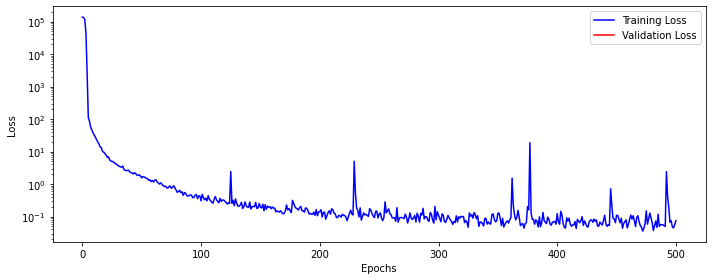

In [11]:
sbs.plot_losses()

In [12]:
sbs.losses[-1]

0.07463913026731461

## Model inference

In [26]:
dataset_dir = "./datasets/inference"
img_size = CFGS["model"]["image_size"]

transforms = Compose(
    [Resize((img_size, img_size)),
     ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

infer_dataset = myDataset(
    root_A= os.path.join(dataset_dir, "horses"),
    root_B= os.path.join(dataset_dir, "zebra"),
    transform=transforms
)

inference_loader = DataLoader(infer_dataset, shuffle=True, batch_size=1)

In [27]:
condition = next(iter(inference_loader))[1]

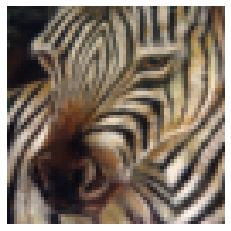

In [28]:
sbs.plot_samples(condition)

In [29]:
samples_x = sbs.translate(target_domain="x", condition=condition, num_steps=1500)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


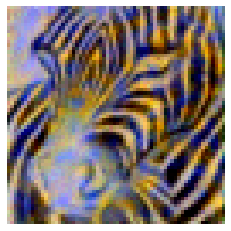

In [30]:
sbs.plot_samples(samples_x)